In [2]:
import numpy as np
import xarray as xr

# Prepare test data

In [83]:
ds = xr.open_dataset('/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/data/ECMWF_TROP_202402151200_202402151200_1.nc', chunks={})
ds

<xarray.Dataset> Size: 29GB
Dimensions:    (time: 1, level: 137, latitude: 2560, longitude: 5120)
Coordinates:
  * longitude  (longitude) float32 20kB 2.501e-07 0.07031 0.1406 ... 359.9 359.9
  * latitude   (latitude) float32 10kB 89.95 89.88 89.81 ... -89.88 -89.95
  * level      (level) int32 548B 1 2 3 4 5 6 7 ... 131 132 133 134 135 136 137
  * time       (time) datetime64[ns] 8B 2024-02-15T12:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 7GB dask.array<chunksize=(1, 28, 512, 1024), meta=np.ndarray>
    t          (time, level, latitude, longitude) float32 7GB dask.array<chunksize=(1, 28, 512, 1024), meta=np.ndarray>
    q          (time, level, latitude, longitude) float32 7GB dask.array<chunksize=(1, 28, 512, 1024), meta=np.ndarray>
    lnsp       (time, level, latitude, longitude) float32 7GB dask.array<chunksize=(1, 28, 512, 1024), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2025-03-04 22:54:08 GMT by grib_to_netcdf-2.28.1: grib_to_n...

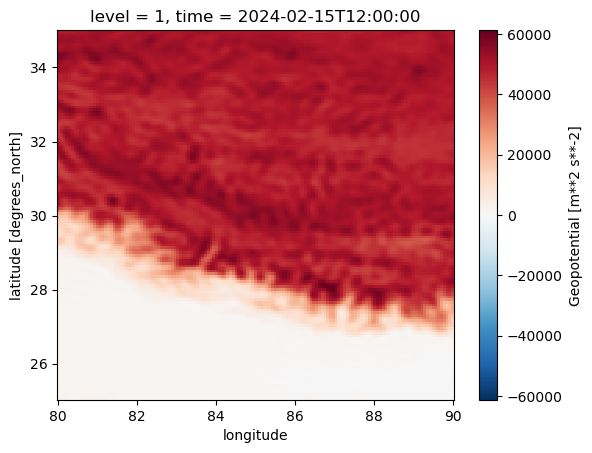

In [86]:
%matplotlib inline
isel = dict(longitude=slice(80, 90), latitude=slice(35, 25))
ds.isel(time=0, level=0).z.sel(isel).plot.imshow()

In [88]:
ds.sel(isel).to_netcdf('/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/tropo/tests/data/test_data.nc')

## Calculate

In [89]:
ds1 = xr.open_dataset('/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/tropo/tests/data/test_data.nc')

In [90]:
from RAiDER.models import HRES
hres_model = HRES()

# Extract temperature and specific humidity at the first time step
hres_model._t = ds1.t.isel(time=0).values
hres_model._q = ds1.q.isel(time=0).values

# Extract longitude and latitude values
longitude = ds1.longitude.values
latitude = ds1.latitude.values

# Use geopotential heights and log of surface pressure
# to get pressure, geopotential, and geopotential height
geop, pres, hgt = hres_model._calculategeoh(
        ds1.z.isel(time=0, level=0).values,
        ds1.lnsp.isel(time=0, level=0).values
)
hres_model._p = pres

# Create latitude and longitude grid
hres_model._lons, hres_model._lats = np.meshgrid(longitude, latitude)

# Get altitudes
hres_model._get_heights(hres_model._lats, hgt.transpose(1, 2, 0))
h = hres_model._zs.copy()

In [91]:
ds1['p']= xr.DataArray(pres[np.newaxis, :],
                       dims=['time', 'level', 'latitude', 'longitude'])
ds1['p']=ds1['p'].assign_attrs({'units':"Pa", 'long_name': "Pressure at Model Levels", 'standard_name': 'air_pressure'})
ds1['geop']= xr.DataArray(geop[np.newaxis, :],
                        dims=['time', 'level', 'latitude', 'longitude'])
ds1['geop']=ds1['geop'].assign_attrs({'units':"m²/s²", 'long_name': "Geopotential", 'standard_name': 'geopotential'})
ds1['ght']= xr.DataArray(hgt[np.newaxis, :],
                        dims=['time', 'level', 'latitude', 'longitude'])
ds1['ght']=ds1['ght'].assign_attrs({'units':"m", 'long_name': "Geopotential heights", 'standard_name': 'geopotential_heights'})
ds1['hgt']= xr.DataArray(hres_model._zs.transpose(2,0,1)[np.newaxis, :],
                        dims=['time', 'level', 'latitude', 'longitude'])
ds1['hgt']=ds1['hgt'].assign_attrs({'units':"m", 'long_name': "Ellispoidal heights", 'standard_name': 'ellipsoidal_heights'})

In [92]:
# Re-structure arrays from (heights, lats, lons) to (lons, lats, heights)
hres_model._p = np.flip(hres_model._p.transpose(1, 2, 0), axis=2)
hres_model._t = np.flip(hres_model._t.transpose(1, 2, 0), axis=2)
hres_model._q = np.flip(hres_model._q.transpose(1, 2, 0), axis=2)
hres_model._zs = np.flip(h, axis=2)
hres_model._find_e()  # Compute partial pressure of water vapor

In [93]:
ds1['e']= xr.DataArray(hres_model._e.transpose(2,0,1)[np.newaxis, :],
                        dims=['time', 'level', 'latitude', 'longitude'])
ds1['e']=ds1['e'].assign_attrs({'units':"Pa", 'long_name': "Partial Pressure of Water Vapor",
                                'standard_name': 'water_vapor_partial_pressure'})

In [95]:
encoding_defaults = {
        "zlib": True,
        "complevel": 4,
        "shuffle": True}
encoding = {var: encoding_defaults for var in ds1.data_vars}
ds1

<xarray.Dataset> Size: 111MB
Dimensions:    (time: 1, level: 137, latitude: 142, longitude: 143)
Coordinates:
  * longitude  (longitude) float32 572B 80.02 80.09 80.16 ... 89.86 89.93 90.0
  * latitude   (latitude) float32 568B 34.97 34.9 34.83 ... 25.2 25.13 25.06
  * level      (level) int32 548B 1 2 3 4 5 6 7 ... 131 132 133 134 135 136 137
  * time       (time) datetime64[ns] 8B 2024-02-15T12:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 11MB ...
    t          (time, level, latitude, longitude) float32 11MB ...
    q          (time, level, latitude, longitude) float32 11MB ...
    lnsp       (time, level, latitude, longitude) float32 11MB ...
    p          (time, level, latitude, longitude) float32 11MB 0.0 ... 1.014e+05
    geop       (time, level, latitude, longitude) float32 11MB 7.56e+05 ... 1...
    ght        (time, level, latitude, longitude) float32 11MB 7.709e+04 ... ...
    hgt        (time, level, latitude, longitude) float64 22MB 7.811e+04 ... ...
    e          (time, level, latitude, longitude) float32 11MB 42.89 ... -1.5...
Attributes:
    Conventions:  CF-1.6
    history:      2025-03-04 22:54:08 GMT by grib_to_netcdf-2.28.1: grib_to_n...

In [97]:
ds1.to_netcdf('/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/tropo/tests/data/test_dataset.nc',
              encoding=encoding)

In [98]:
# Output
hres_model._uniform_in_z(_zlevels=None)
hres_model._checkForNans()
hres_model._get_wet_refractivity()
hres_model._get_hydro_refractivity()
hres_model._adjust_grid(hres_model.get_latlon_bounds())

# Compute zenith delays at the weather model grid nodes
hres_model._getZTD()

In [106]:
dims = ['time', 'latitude', 'longitude', 'height']
out = xr.Dataset(data_vars = dict(
    hydrostatic_refractivity = (dims, hres_model._hydrostatic_refractivity[np.newaxis, :]),
    wet_refractivity = (dims, hres_model._wet_refractivity[np.newaxis, :]),
    hydrostatic_ztd = (dims, hres_model._hydrostatic_ztd[np.newaxis, :]),
    wet_ztd = (dims, hres_model._wet_ztd[np.newaxis, :])),
    coords = dict(
        time=ds1.time,
        height=hres_model._zs,
        latitude=ds1.latitude,
        longitude=ds1.longitude,
    ))
out['longitude'] =out['longitude'].assign_attrs({'unit':'degrees_east','standard_name':'longitude','long_name':'Longitude'})
out['height'] =out['height'].assign_attrs({'unit':'m','standard_name':'ellipsoidal_height','long_name':'Ellipsoidal height'})
out['hydrostatic_refractivity'] = out['hydrostatic_refractivity'].assign_attrs({'unit':'dimensionless', 'standard_name':'hydrostatic_refractivity', 'long_name':'Hydrostatic Refractivity'})
out['wet_refractivity'] = out['wet_refractivity'].assign_attrs({'unit':'dimensionless', 'standard_name':'wet_refractivity', 'long_name':'Wet Refractivity'})
out['hydrostatic_ztd'] = out['hydrostatic_ztd'].assign_attrs({'unit':'m', 'standard_name':'hydrostatic_ztd', 'long_name':'Zenith Intgrated Hydrostatic Delay'})
out['wet_ztd'] = out['wet_ztd'].assign_attrs({'unit':'dimensionless', 'm':'wet_ztd', 'long_name':'Zenith Intgrated Wet Delay'})

In [107]:
out

<xarray.Dataset> Size: 71MB
Dimensions:                   (time: 1, latitude: 142, longitude: 143,
                               height: 145)
Coordinates:
  * time                      (time) datetime64[ns] 8B 2024-02-15T12:00:00
  * latitude                  (latitude) float32 568B 34.97 34.9 ... 25.13 25.06
  * longitude                 (longitude) float32 572B 80.02 80.09 ... 90.0
  * height                    (height) float64 1kB -500.0 -300.0 ... 8.03e+04
Data variables:
    hydrostatic_refractivity  (time, latitude, longitude, height) float32 12MB ...
    wet_refractivity          (time, latitude, longitude, height) float32 12MB ...
    hydrostatic_ztd           (time, latitude, longitude, height) float64 24MB ...
    wet_ztd                   (time, latitude, longitude, height) float64 24MB ...

In [108]:
encoding_defaults = {
        "zlib": True,
        "complevel": 4,
        "shuffle": True}
encoding = {var: encoding_defaults for var in out.data_vars}
out.to_netcdf('/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/tropo/tests/data/output_data.nc')

# Tests

In [137]:
import pytest
from pathlib import Path
DATA_DIR = Path('/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/tropo/tests')/ "data"
#@pytest.fixture(scope="session")
def load_input_model() -> xr.Dataset:
    """Load the golden input dataset."""
    file_path = DATA_DIR / "test_dataset.nc"
    if not file_path.exists():
        pytest.fail(f"Missing test file: {file_path}")

    with xr.open_dataset(file_path) as ds:
        return ds.load()  # Ensure data is loaded into memory
    
#@pytest.fixture(scope="session")
def init_raider(load_input_model):
    # load test data
    da = load_input_model

    # Init RAIDER
    hres_model = HRES()

    # Extract temperature and specific humidity at the first time step
    hres_model._t = da.t.isel(time=0).values
    hres_model._q = da.q.isel(time=0).values

    # Extract longitude and latitude values
    longitude = da.longitude.values
    latitude = da.latitude.values

    # Create latitude and longitude grid
    hres_model._lons, hres_model._lats = np.meshgrid(longitude, latitude)
    return hres_model


In [142]:
da = load_input_model()

In [151]:
da

<xarray.Dataset> Size: 111MB
Dimensions:    (time: 1, level: 137, latitude: 142, longitude: 143)
Coordinates:
  * longitude  (longitude) float32 572B 80.02 80.09 80.16 ... 89.86 89.93 90.0
  * latitude   (latitude) float32 568B 34.97 34.9 34.83 ... 25.2 25.13 25.06
  * level      (level) int32 548B 1 2 3 4 5 6 7 ... 131 132 133 134 135 136 137
  * time       (time) datetime64[ns] 8B 2024-02-15T12:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 11MB 4.859e+04 ... nan
    t          (time, level, latitude, longitude) float32 11MB 201.5 ... 296.8
    q          (time, level, latitude, longitude) float32 11MB 1.816e-06 ... ...
    lnsp       (time, level, latitude, longitude) float32 11MB 10.92 ... nan
    p          (time, level, latitude, longitude) float32 11MB 0.0 ... 1.014e+05
    geop       (time, level, latitude, longitude) float32 11MB 7.56e+05 ... 1...
    ght        (time, level, latitude, longitude) float32 11MB 7.709e+04 ... ...
    hgt        (time, level, latitude, longitude) float64 22MB 7.811e+04 ... ...
    e          (time, level, latitude, longitude) float32 11MB 42.89 ... -1.5...
Attributes:
    Conventions:  CF-1.6
    history:      2025-03-04 22:54:08 GMT by grib_to_netcdf-2.28.1: grib_to_n...

In [144]:
model = init_raider(load_input_model())

In [182]:
def test_raider_preparing_model():
    # Init RAiDER HRES instance
    model = init_raider(load_input_model())

    # load test data
    da = load_input_model().isel(time=0)

    # Step 1: Calculate surface_pressure, geopotenial heights
    geop, pres, hgt = model._calculategeoh(
        da.z.isel(level=0).values, da.lnsp.isel(level=0).values
    )

    err_msg="f:_calculategeoh %s values do not match!"
    np.testing.assert_allclose(da.geop, geop,
                               err_msg=err_msg % 'geopotential')
    np.testing.assert_allclose(da.p, pres,
                               err_msg=err_msg % 'surface_pressure')
    np.testing.assert_allclose(da.ght, hgt,
                               err_msg=err_msg % 'geo_height')

    # Step 2: Convert geoheight to ellipsoidal heights
    model._p = pres
    model._get_heights(model._lats, hgt.transpose(1, 2, 0))
    h = model._zs.copy()

    err_msg="f:_get_heights %s values do not match!"
    np.testing.assert_allclose(da.hgt, h.transpose(2,0,1),
                               err_msg=err_msg % 'ellipsoidal_height')

    # Step 3: Get partial water vapor pressure
    model._p = np.flip(model._p.transpose(1, 2, 0), axis=2)
    model._t = np.flip(model._t.transpose(1, 2, 0), axis=2)
    model._q = np.flip(model._q.transpose(1, 2, 0), axis=2)
    model._zs = np.flip(h, axis=2)
    model._find_e()  # Compute partial pressure of water vapor

    err_msg="f:_find_e %s values do not match!"
    np.testing.assert_allclose(da.e, model._e.transpose(2,0,1),
                               err_msg=err_msg % 'partial_water_vapor')

In [ ]:
model

In [183]:
test_raider_preparing_model()

In [147]:
# test _calculategeoh

geop, pres, hgt = model._calculategeoh(
        da.z.isel(time=0, level=0).values, da.lnsp.isel(time=0, level=0).values
    )

In [150]:
import numpy as np

In [157]:
da.geop.shape, geop.shape

((1, 137, 142, 143), (137, 142, 143))

In [169]:
err_msg="f:_calculategeoh %s values do not match!"
np.testing.assert_allclose(da.geop.isel(time=0), geop, err_msg=err_msg % 'geopotential')
np.testing.assert_allclose(da.p.isel(time=0), pres, err_msg=err_msg % 'surface_pressure')
np.testing.assert_allclose(da.ght.isel(time=0), hgt+1, err_msg=err_msg % 'geo_height')

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0
f:_calculategeoh geo_height values do not match!
Mismatched elements: 2781922 / 2781922 (100%)
Max absolute difference: 1.0009766
Max relative difference: 0.3929079
 x: array([[[7.709105e+04, 7.709234e+04, 7.709529e+04, ..., 7.715857e+04,
         7.715988e+04, 7.715860e+04],
        [7.709633e+04, 7.709856e+04, 7.709595e+04, ..., 7.716291e+04,...
 y: array([[[7.709205e+04, 7.709334e+04, 7.709629e+04, ..., 7.715957e+04,
         7.716088e+04, 7.715960e+04],
        [7.709733e+04, 7.709956e+04, 7.709695e+04, ..., 7.716391e+04,...